#**Prediksi Rata-rata Tingkat Polutan Kualitas Udara DKI Jakarta Berdasarkan Indeks Standar Pencemaran Udara (ISPU) menggunakan metode Long Short-Term Memory (LSTM)**
Tugas Akhir Kelompok 5 - Kelas UGM03

Anggota:


* Bagus Dwi Hariyanto
* Faiz Khansa Adrika
* Sharon Syalomitha



##**Deskripsi Data Perkembangan Indeks Standar Pencemaran Udara Wilayah DKI Jakarta**

Data ini merupakan data sekunder yang diambil melalui website [Jakarta Open Data](https://data.jakarta.go.id/) dan dibuat oleh Dinas Lingkungan Hidup DKI Jakarta

Dataset time-series terstruktur ini berisi mengenai Indeks Standar Pencemar Udara (ISPU) yang diukur dari 5 stasiun pemantau kualitas udara (SPKU) yang ada di Provinsi DKI Jakarta periode Januari 2018 -Juli Tahun 2021

Penjelasan variabel dari data sebagai berikut :

1. tanggal : Tanggal pengukuran kualitas udara
3. pm10 : Partikulat salah satu parameter yang diukur
5. so2 : Sulfida (dalam bentuk SO2) salah satu parameter yang diukur
6. co : Carbon Monoksida salah satu parameter yand diukur
7. o3 : Ozon salah satu parameter yang diukur
8. no2 : NItrogen dioksida salah satu parameter yang diukur
9. max : Nilai ukur paling tinggi dari seluruh parameter yang diukur dalam waktu yang sama
10. critical : Parameter yang hasil pengukurannya paling tinggi
11. categori : Kategori hasil perhitungan indeks standar pencemaran udara
11. lokasi_spku : Stasiun pengukuran

##Library yang dibutuhkan

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

##Pengambilan Data

Data ini diambil secara manual melalui website Jakarta Open Data yang menyediakan dataset ISPU terpisah setiap bulannya, sehingga diperlukan penggabungan (concatenation) data dari bulan Januari 2018 - Juli 2021

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir='/content/drive/MyDrive/MC AI/Total'
files = os.listdir(dir) #Folder tempat kumpulan dataset bulan Januari-Juli
#Kolom sesuai variabel dataset
df = pd.DataFrame(columns=['tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max',
       'critical', 'categori','lokasi_spku'])

#Memuat data ke dataframe pandas dan penggabungan (concatenation) data dari 1 folder
for file in files:
  df_all = pd.read_csv(os.path.join(dir,file))
  df = pd.concat([df, df_all], ignore_index=True) #Data yang diambil hanya dari SPKU DKI1 yang terletak di Bunderan HI
  df = df.sort_values(by='tanggal', ascending=True) #Mengurutkan data berdasar tanggal

df

,tanggal,pm10,so2,co,o3,no2,max,critical,categori,lokasi_spku,pm25,Unnamed: 10
0,2018-01-01,76,31,38,35,9,76,PM10,SEDANG,DKI4,NaN,NaN
1,2018-01-02,23,31,24,39,14,39,O3,BAIK,DKI3,NaN,NaN
2,2018-01-03,53,35,35,101,23,101,O3,TIDAK SEHAT,DKI3,NaN,NaN
3,2018-01-04,53,49,34,57,15,57,O3,SEDANG,DKI3,NaN,NaN
4,2018-01-05,44,32,26,28,10,44,PM10,BAIK,DKI4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,2021-07-27,82,56,13,41,35,140,PM25,TIDAK SEHAT,DKI4,140.0,NaN
1272,2021-07-28,82,53,18,40,45,145,PM25,TIDAK SEHAT,DKI4,145.0,NaN
1273,2021-07-29,78,52,18,53,39,140,PM25,TIDAK SEHAT,DKI5,140.0,NaN
1274,2021-07-30,90,54,15,81,35,154,PM25,TIDAK SEHAT,DKI4,154.0,NaN


**Data Exploration/Menelaah Data**

In [ ]:
df.drop(['lokasi_spku','pm25','max','critical','categori','Unnamed: 10'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1275
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tanggal  1307 non-null   object
 1   pm10     1288 non-null   object
 2   so2      1288 non-null   object
 3   co       1288 non-null   object
 4   o3       1288 non-null   object
 5   no2      1288 non-null   object
dtypes: object(6)
memory usage: 71.5+ KB


Berdasarkan hasil output di atas, dapat diketahui bahwa terdapat 19 data kosong per variabel pada data tersebut sehingga harus diatasi. 

In [ ]:
df['tanggal'] = pd.to_datetime(df['tanggal']) #Mengubah tipe data 'tanggal'
df.set_index('tanggal', inplace=True) #Membuat 'tanggal' menjadi index pada dataframe

In [ ]:
df[df.eq("---").any(1)] #mencari data dengan input '---' yang artinya nilai tidak tercatat

,pm10,so2,co,o3,no2
tanggal,,,,,
2020-03-02,22,---,35,213,11
2020-03-03,22,---,---,201,15
2020-03-04,54,---,39,152,13
2020-03-05,59,---,32,206,5
2020-03-20,69,---,33,99,7
2020-03-21,51,---,11,83,8
2020-03-22,42,---,15,84,6
2020-03-23,27,---,5,71,7
2020-03-24,52,---,14,105,7


In [ ]:
df = df.replace('---', 0)
df = df.replace(np.nan,0)

In [ ]:
#Mengubah tipe data menjadi numerik
df[['pm10', 'so2', 'co', 'o3', 'no2']] = df[['pm10', 'so2', 'co', 'o3', 'no2']].apply(pd.to_numeric)

In [ ]:
df.describe()

,pm10,so2,co,o3,no2
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,61.636572,36.373374,23.820199,94.258607,23.553175
std,16.817332,19.203149,11.010810,45.744836,21.858991
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,53.000000,25.000000,17.000000,60.000000,12.000000
50%,64.000000,30.000000,22.000000,86.000000,16.000000
75%,73.000000,42.000000,29.000000,122.500000,23.000000
max,134.000000,126.000000,88.000000,243.000000,148.000000


Mengatasi masalah missing value dengan impute data menggunakan nilai mean dan melakukan pemeriksaan ulang.

In [ ]:
#Impute data dengan nilai mean
for col in df.columns:
    val = df[col].mean()
    df[col] = df[col].replace(0, val)

In [ ]:
#Memperlihatkan jumlah data kosong (missing value) di setiap kolomnya
df.isna().sum()

pm10    0
so2     0
co      0
o3      0
no2     0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1307 entries, 2018-01-01 to 2021-07-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm10    1307 non-null   float64
 1   so2     1307 non-null   float64
 2   co      1307 non-null   float64
 3   o3      1307 non-null   float64
 4   no2     1307 non-null   float64
dtypes: float64(5)
memory usage: 61.3 KB


Menambahkan variabel baru (average) dimana variabel tersebut merupakan nilai rata-rata zat pencemar udara yaitu PM10, SO2, CO, O3, dan NO2 dalam periode harian. 

In [ ]:
#menambahkan nilai rata-rata dari seluruh polutan dalam periode harian
df['average'] = df.mean(numeric_only=True, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1307 entries, 2018-01-01 to 2021-07-31
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pm10     1307 non-null   float64
 1   so2      1307 non-null   float64
 2   co       1307 non-null   float64
 3   o3       1307 non-null   float64
 4   no2      1307 non-null   float64
 5   average  1307 non-null   float64
dtypes: float64(6)
memory usage: 71.5 KB


In [ ]:
df

,pm10,so2,co,o3,no2,average
tanggal,,,,,,
2018-01-01,76.0,31.0,38.0,35.0,9.0,37.8
2018-01-02,23.0,31.0,24.0,39.0,14.0,26.2
2018-01-03,53.0,35.0,35.0,101.0,23.0,49.4
2018-01-04,53.0,49.0,34.0,57.0,15.0,41.6
2018-01-05,44.0,32.0,26.0,28.0,10.0,28.0
...,...,...,...,...,...,...
2021-07-27,82.0,56.0,13.0,41.0,35.0,45.4
2021-07-28,82.0,53.0,18.0,40.0,45.0,47.6
2021-07-29,78.0,52.0,18.0,53.0,39.0,48.0


In [ ]:
df.shape

(1307, 6)

In [ ]:
df.describe()

,pm10,so2,co,o3,no2,average
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,62.532590,37.263923,24.202926,95.628855,23.895570,48.704773
std,15.058202,18.318029,10.581481,44.288311,21.670891,12.563854
min,20.000000,9.000000,5.000000,18.000000,3.000000,21.600000
25%,54.000000,25.000000,17.000000,62.000000,12.000000,40.000000
50%,64.000000,31.000000,22.000000,88.000000,16.000000,46.800000
75%,73.000000,42.000000,29.000000,122.500000,23.553175,55.800000
max,134.000000,126.000000,88.000000,243.000000,148.000000,98.800000


##Splitting data

Selanjutnya, data dibagi menjadi dua bagian yaitu training dan testing. Pembagian dataset diatur dengan persentase 77% untuk training dan 23% untuk testing. 

In [ ]:
df_train = df.loc['2018-01-01':'2020-09-30'] #data training adalah data dalam periode 1 Januari 2018 sampai 30 September 2020
df_test = df.loc['2020-10-01':'2021-07-31'] #data testing adalah data dalam periode 30 September 2020 sampai 7 Juli 2021

In [ ]:
df_train

,pm10,so2,co,o3,no2,average
tanggal,,,,,,
2018-01-01,76.0,31.0,38.0,35.0,9.0,37.8
2018-01-02,23.0,31.0,24.0,39.0,14.0,26.2
2018-01-03,53.0,35.0,35.0,101.0,23.0,49.4
2018-01-04,53.0,49.0,34.0,57.0,15.0,41.6
2018-01-05,44.0,32.0,26.0,28.0,10.0,28.0
...,...,...,...,...,...,...
2020-09-26,73.0,105.0,30.0,118.0,99.0,85.0
2020-09-27,70.0,96.0,31.0,98.0,93.0,77.6
2020-09-28,74.0,77.0,31.0,97.0,79.0,71.6


In [ ]:
df_test

,pm10,so2,co,o3,no2,average
tanggal,,,,,,
2020-10-01,73.0,83.0,32.0,73.0,62.0,64.6
2020-10-02,83.0,89.0,35.0,87.0,79.0,74.6
2020-10-03,74.0,77.0,32.0,80.0,89.0,70.4
2020-10-04,79.0,83.0,33.0,108.0,95.0,79.6
2020-10-05,62.0,64.0,32.0,109.0,128.0,79.0
...,...,...,...,...,...,...
2021-07-27,82.0,56.0,13.0,41.0,35.0,45.4
2021-07-28,82.0,53.0,18.0,40.0,45.0,47.6
2021-07-29,78.0,52.0,18.0,53.0,39.0,48.0


In [ ]:
print(df_train.shape, df_test.shape)

(1003, 6) (304, 6)


Setelah melakukan pembagian data yang menghasilkan 1003 data untuk data training dan 304 data untuk data testing, tahapan selanjutnya adalah Normalisasi Data. Normalisasi data dilakukan dengan menyamaratakan rentang nilai pada numerical data sehingga nilainya berkisar antara 0 dan 1 atau rentang [0,1]. 

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_train['average'].values.reshape(-1,1))

In [ ]:
# how many days do i want to base my predictions on ?
prediction_days = 5

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

##Pembuatan model dengan menggunakan metode *Long Short-Term Memory* (LSTM) 

In [ ]:
model = Sequential()
    
model.add(LSTM(units = 50,activation="tanh", return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50,activation="tanh", return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50,activation="tanh"))
model.add(Dropout(0.2))
    
model.add(Dense(units=1))

model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.002):
      print("\nReached 0,005 so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

model.fit(x_train, 
          y_train, 
          epochs=50,
          callbacks = [callbacks])

Epoch 1/50
32/32 [==============================] - 6s 10ms/step - loss: 0.0449
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0200
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0183
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0184
Epoch 6/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0188
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0181
Epoch 8/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 9/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 10/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0172
Epoch 11/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 12/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 13/50
32/32 [==================

Implementasi pada tahap pelatihan model LSTM dengan layer epoch yang digunakan sebanyak 300 menghasilkan nilai loss sebesar 0,110.

In [ ]:
test_data = df_test

actual_avg = df_test['average'].values

total_dataset = df['average']

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
#Memasukkan x_test untuk prediksi
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_value = model.predict(x_test)
predicted_value = scaler.inverse_transform(predicted_value)

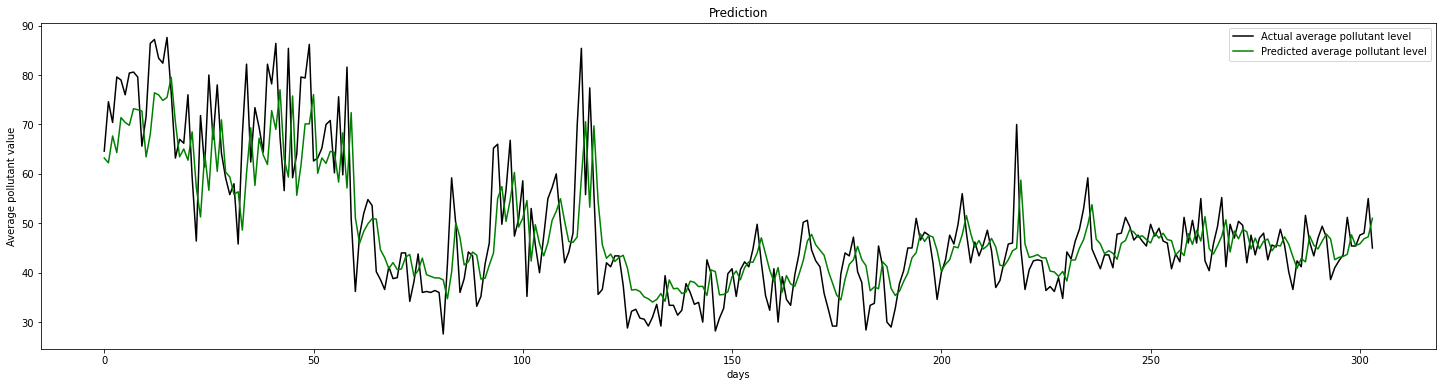

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(actual_avg, color='black', label="Actual average pollutant level")
plt.plot(predicted_value, color= 'green', label="Predicted average pollutant level")
plt.title("Prediction")
plt.xlabel("days")
plt.ylabel("Average pollutant value")
plt.legend()
plt.show()

Hasil dari prediksi rata-rata ISPU DKI Jakarta 1 (Bundaran HI) menggunakan pemodelan LSTM akan divisualisasi dalam bentuk plot diagram. Diagram di atas membandingkan data rata-rata asli yang diwakilkan garis berwarna hitam dengan rata-rata hasul prediksi dari model yang diwakilkan dengan garis berwarna hijau. 

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(actual_avg, predicted_value)
mape

0.12239162150101576

In [ ]:
from pickle import dump
dump(model, open('model.pkl', 'wb'))
dump(scaler, open('scaler.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://915f900b-bc89-4dc8-8630-96135c8b5b5b/assets


INFO:tensorflow:Assets written to: ram://915f900b-bc89-4dc8-8630-96135c8b5b5b/assets


In [ ]:
d1, d2, d3, d4, d5 = 45, 49, 54,40,50
dt = np.array([[d1],[d2],[d3],[d4],[d5]])
dt = scaler.transform(dt)
dt = dt.reshape(1,-1,1)
pred = model.predict(dt)
pred = scaler.inverse_transform(pred)
pred

array([[48.245598]], dtype=float32)

In [ ]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
